<a href="https://colab.research.google.com/github/maryammoayedi/Artificial-intelligence-/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Most machine learning workflows involve working with data, creating models, optimizing model parameters, and saving the trained models.
# Complete ML workflow implemented in PyTorch : https://pytorch.org/tutorials/beginner/basics/intro.html
# Neural Networks explained here: https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# @title plotting functions

from matplotlib import pyplot as plt
from tqdm import trange

def visualize(images, labels):
    """
    Visualize a batch of images.
    """
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def visualize_predictions(images, labels, predicted_labels):
    """
    Visualize a batch of images with their true and predicted labels.
    Titles are green if the prediction is correct, red if incorrect.
    """
    fig, axes = plt.subplots(8, 8, figsize=(11, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if labels[i].item() == predicted_labels[i].item() else 'red'
        ax.set_title(f'True: {labels[i].item()}\nPred: {predicted_labels[i].item()}', color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_conf_mat(model, dataloader, device):
    """
    Plot the confusion matrix for a given model and dataloader.
    """
    # Initialize the confusion matrix
    total, correct = 0, 0
    conf_mat = torch.zeros((10, 10))
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis=1)
            correct += sum(pred == y).item()
            for j in range(pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1
    # calculate the normalized confusion matrix
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()

In [ ]:
#َUse datasets from torchvision to load the MNIST handwritten digits dataset.
#root sets the directory we store and load our data from.
#train indicates wether we want the training dataset or the test dataset.
#transform allows us to apply transformations to our data, here we are only going to convert the data to tensor so that they work with PyToch
# datasets are here:  https://pytorch.org/vision/0.8/datasets.html

# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


print(f"Training data: {training_data}\n")
print(f"Test data: {test_data}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.1MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.29MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.21MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training data: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
#To make loading and working with the data easier, we are going to use DataLoader from torch.utils.data. The DataLoader takes in a dataset and a batch_size parameter,
#and allows us to iterate over the dataset. Here we do one iteration just to see the data shapes:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Iterate over the data
for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


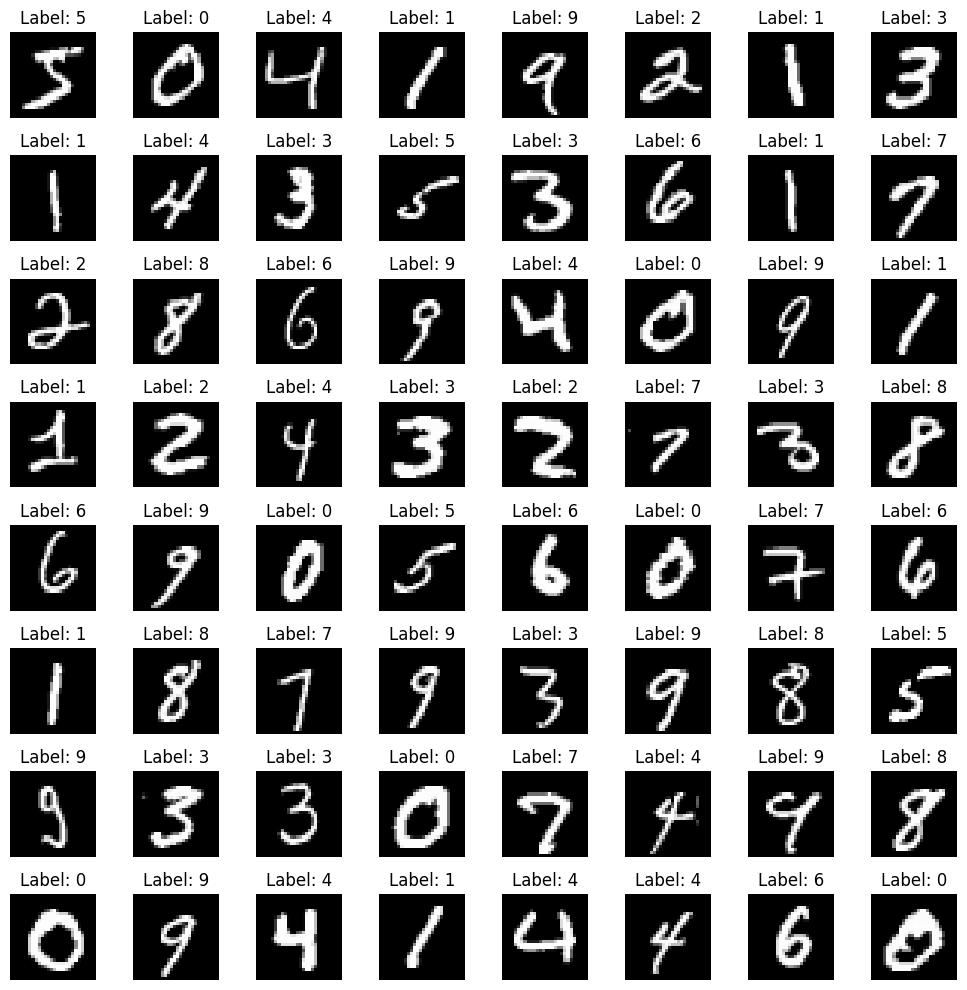

In [ ]:
images, labels = next(iter(train_dataloader))

visualize(images, labels)

In [ ]:
# To accelerate operations in the neural network, we move it to the GPU or MPS (for Apple silicon) if available.
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
# Here we define our model. Recall that each batch of image has a shape of [64, 1, 28, 28]. For now we only want to use Linear layers so we must flatten the inputs
# so that we can pass it to the linear layers. The nn.Flatten() module allows us to do this.

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
#Next we initialize our model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
# Since we are trying to classify the handwritten digits, we are going to use the cross entropy loss. You can see the list of loss functions in PyTorch here.
loss_fn = nn.CrossEntropyLoss()


In [ ]:
# we need to setup an optimizer for training our model. We use stochastic gradient descent so we have must use the SGD module from torch.optim.
#We must pass the model.parameters() to the SGD optimizer and set its learning rate lr=1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# To train the model we first set the number of epochs. For each epoch we then iterate over the entire training data and update the model parameters.
# For each batch of data, we must first move the data to same device as the network, then we predict the output of the model, calculate the loss, perform backward pass,
#update parameters, and reset the gradients.
#To monitor training, we use trange from tqdm which performs similar to range but allows us to have a progress bar pbar which lets us display useful information.

# Number of epochs we wish to train the model
n_epochs = 30

for _ in (pbar := trange(n_epochs)):
    # Iterate over the data
    for x, y in train_dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the progress bar
        pbar.set_description(f'Loss = {loss.item():.3f}')

Loss = 0.168: 100%|██████████| 30/30 [10:19<00:00, 20.65s/it]


In [ ]:
#Finally we can evaluate the trained model. We will start by evaluating the model on the test dataset. Here we use torch.no_grad() since we don't need the gradients.
#We iterate over the entire test dataset and print the accuracy of our model on this dataset.

# Store the number of correctly classified and total labels
correct, total = 0, 0

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the test data
    for x, y in test_dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Predict the output
        logits = model(x)
        # Get the predicted label
        pred = torch.argmax(logits, axis=1)
        # Update the number of correclty classified labels
        correct += sum(pred == y).item()
        # Update the number of total labels
        total += pred.shape[0]

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 90.56%


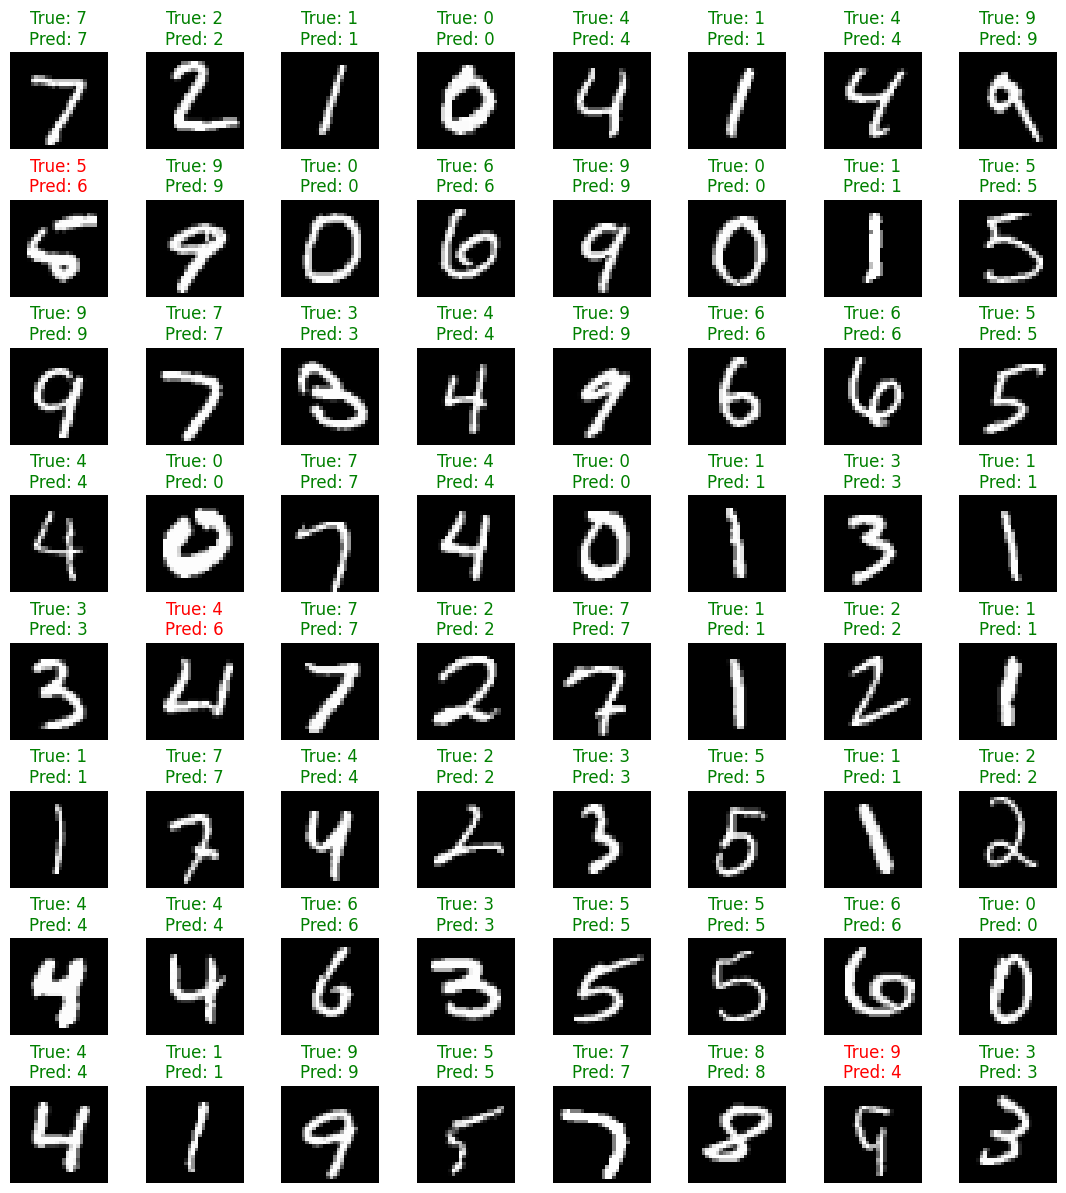

In [ ]:
images, labels = next(iter(test_dataloader))
preds = torch.argmax(model(images.to(device)), axis=1).cpu()

visualize_predictions(images, labels, preds)

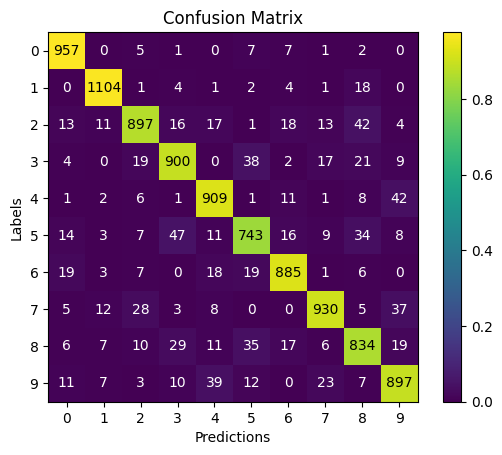

In [ ]:
plot_conf_mat(model, test_dataloader, device)

Loss = 1.601 | Accuracy = 72.67% : 100%|██████████| 10/10 [02:10<00:00, 13.05s/it]


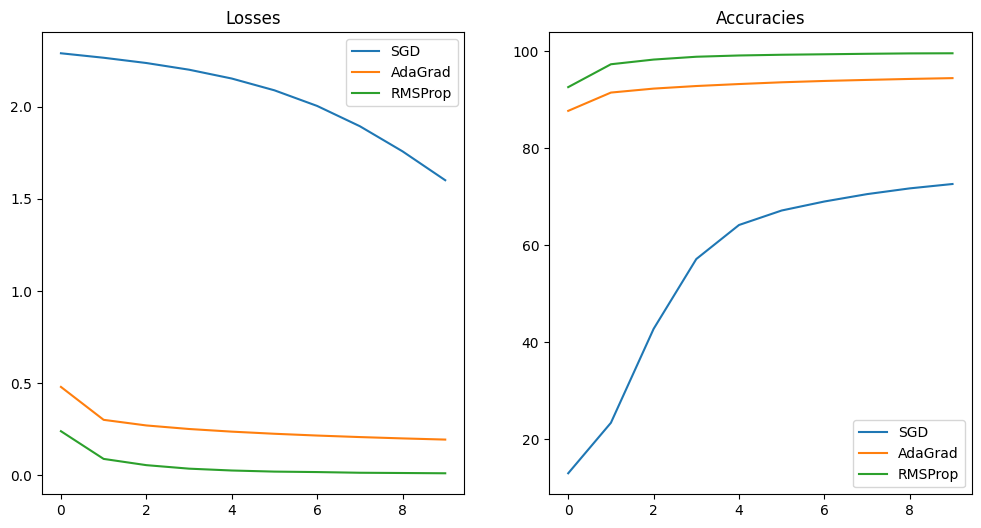

Dropdown(description='Optimizer:', layout=Layout(width='200px'), options=('SGD', 'AdaGrad', 'RMSProp', 'Adam')…


Adam


Loss = 0.015 | Accuracy = 99.48% : 100%|██████████| 10/10 [02:38<00:00, 15.86s/it]


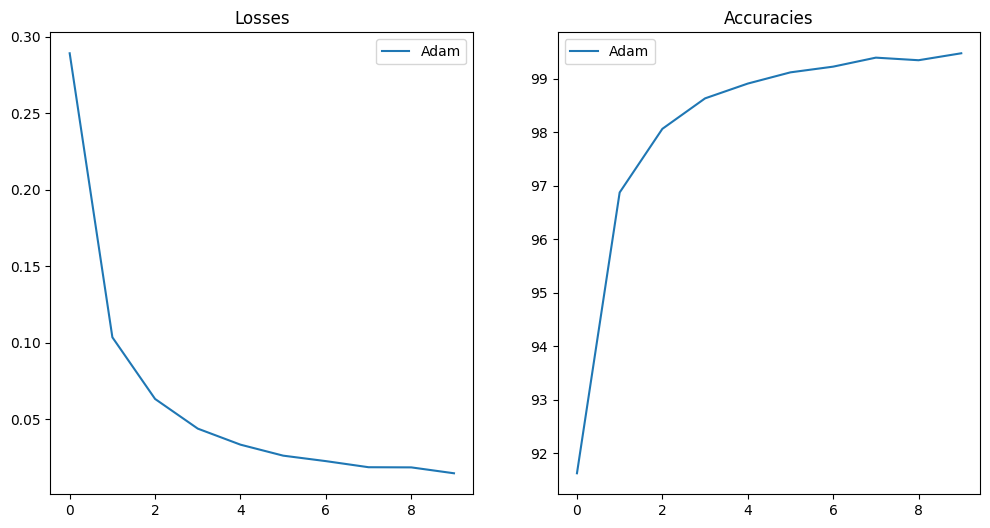

In [ ]:
# we will take a look at different optimizers and how they effect training and convergence. Run the widget bellow to train the model for different optimizers! You can increase the number of epochs or set the hyperparameters of each optimizers manually if you like.

# @markdown Optimizer Experimentation Widget

import ipywidgets as widgets
from IPython.display import display

train_dataloader = DataLoader(training_data, batch_size=128)

def train_model(model, optimizer, n_epochs=10):
    losses, accuracies = [], []
    for _ in (pbar := trange(n_epochs)):
        running_loss, acc = 0, 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            pred = torch.argmax(pred, axis=1)
            acc += sum(pred == y).item()
        acc /= len(train_dataloader.dataset)
        acc *= 100
        running_loss /= len(train_dataloader)
        losses.append(running_loss)
        accuracies.append(acc)
        pbar.set_description(f'Loss = {running_loss:.3f} | Accuracy = {acc:.2f}% ')
    return losses, accuracies


def plot_losses_accuracies(results):
    fig, axes = plt.subplots(1, 2)
    for optimizer, res in results.items():
        if 'losses' not in res or 'accuracies' not in res:
            continue
        losses = res['losses']
        accuracies = res['accuracies']
        axes[0].plot(losses, label=optimizer)
        axes[1].plot(accuracies, label=optimizer)
    axes[0].set_title('Losses')
    axes[1].set_title('Accuracies')
    axes[0].legend()
    axes[1].legend()
    fig.set_size_inches(12, 6)
    plt.show()


# Create a list of values
options = ['SGD', 'AdaGrad', 'RMSProp', 'Adam']

# Create a dropdown widget with custom layout
dropdown = widgets.Dropdown(
    options=options,
    description='Optimizer:',
    layout={'width': '200px'},
    style={'description_width': 'initial'}

)


# Define a function to run based on selected value
def on_value_change(change):
    optimizer = change['new']
    global first_run, resuts
    model = NeuralNetwork().to(device)
    if results[optimizer] != {}:
        losses = results[optimizer]['losses']
        accuracies = results[optimizer]['accuracies']
        plot_losses_accuracies(results)
        return
    if optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=1e-3)
    elif optimizer == 'AdaGrad':
        opt = torch.optim.Adagrad(model.parameters(), lr=1e-3)
    elif optimizer == 'RMSProp':
        opt = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    elif optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    print(f'\n{optimizer}')
    losses, accuracies = train_model(model, opt)
    results[optimizer]['losses'] = losses
    results[optimizer]['accuracies'] = accuracies
    plot_losses_accuracies(results)



# Observe changes in the dropdown value
dropdown.observe(on_value_change, names='value')

results = {optimizer: dict() for optimizer in options}

# on_value_change({"new": 'SGD'})

# Display the widget
display(dropdown)